How do people’s information-related self-efficacy (A5) and their health-related self- efficacy (F2 &amp; N4) relate to

a. their use of social media for health information seeking or sharing (B14),

b. their self-reported health status (F1),

c. their avoidance of doctors (F3),

d. and their perceived social support (F5)?

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to implement regressions
from sklearn.linear_model import LinearRegression

from sklearn import linear_model, metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
df = pd.read_excel("data_level4.xlsx")


In [32]:
#Dict of all questions 
q = {'A5': 'ConfidentGetHealthInf', 
     'F1': 'GeneralHealth',
     'F2': 'OwnAbilityTakeCareHealth',
     'F3': 'AvoidDoc',
     'F5': 'TalkHealthFriends',
     'B14': ['IntRsn_VisitedSocNet','IntRsn_SharedSocNet','IntRsn_WroteBlog','IntRsn_SupportGroup','IntRsn_YouTube'],
     'N4': ['EverythingCauseCancer','PreventNotPossible','TooManyRecommendations']
    }

In [4]:
'''
    Preprocessing steps:
    1. Removing all the columns after index 359. This includes all columns after `MAILNUM` column. 
    2. Remove all the columns with object datatype. 
'''
def preprocess_df(df):
  remove_df = df.iloc[:,359:]
  df = df.drop(remove_df.columns, axis=1)
  object_cols = list(df.select_dtypes(include=['object']).columns)
  print('Removing following columns', object_cols)
  date_cols = list(df.select_dtypes(include=['datetime']).columns)
  print('Removing following columns', date_cols)
  new_df = df.drop(object_cols, axis=1)
  new_df = new_df.drop(date_cols, axis=1)
  print('Removing column : Prompt . [P.S. This contains NaN]')
  new_df = new_df.drop(['Prompt'],axis =1)
  print("New dataframe shape ", new_df.shape)
  return new_df

In [5]:
new_df = preprocess_df(df)

Removing following columns ['PersonID', 'Stratum', 'APP_REGION', 'VAR_STRATUM', 'StrongNeedHealthInfo_OS', 'HealthIns_Other_OS', 'Caregiving_Other_OS', 'CaOther_OS', 'SexualOrientation_OS']
Removing following columns ['UpdateDate']
Removing column : Prompt . [P.S. This contains NaN]
New dataframe shape  (5438, 348)


In [6]:
def create_bar_plot(df,col_ls_1,col_ls_2, figsize = (15,7)):
  temp = df[col_ls_2]
  temp.groupby(col_ls_1).count().plot(kind='bar', figsize = figsize)

def analyse_data(df,col_1, col_2, col_3):
  #removing the rows with missing data
  temp_df = df[df[col_1]>0]
  print("Shape after Filtering ",col_1," : ",temp_df.shape)

  #removing the rows with missing data
  temp_df_2 = temp_df[temp_df[col_2]>0]
  print("Shape after Filtering ",col_2," : ",temp_df_2.shape)
  res = temp_df_2.groupby([col_1,col_2]).count()
  print(res)
  create_bar_plot(temp_df_2, [col_1,col_2], [col_1,col_2, col_3])
  print('Done!!')


 ConfidentGetHealthInf

  A5. Overall, how confident are you that you could get advice or information about health or medical topics if you needed it?

    1.  Completely confident     2.  Very confident
    3.  Somewhat confident       4.  A little confident
    5.  Not confident at all


OwnAbilityTakeCareHealth

F2. Overall, how confident are you about your ability to take good care of your health?

    1.  Completely confident     2.  Very confident
    3.  Somewhat confident       4.  A little confident
    5.  Not confident at all

EverythingCauseCancer

N4a. How much do you agree or disagree: It seems like everything causes cancer

    1.  Strongly agree            2. Somewhat agree
    3.  Somewhat disagree         4. Strongly disagree


PreventNotPossible

N4b. How much do you agree or disagree: There’s not much you can do to lower your chances of getting cancer

    1.  Strongly agree            2. Somewhat agree
    3.  Somewhat disagree         4. Strongly disagree



# Messing around with comparing three cols

Shape after Filtering  ConfidentGetHealthInf  :  (5308, 348)
Shape after Filtering  OwnAbilityTakeCareHealth  :  (5225, 348)
                                                HHID  HIGHSPANLI  HISPSURNAME  \
ConfidentGetHealthInf OwnAbilityTakeCareHealth                                  
1                     1                          633         633          633   
                      2                          531         531          531   
                      3                          168         168          168   
                      4                           27          27           27   
                      5                           11          11           11   
2                     1                          445         445          445   
                      2                         1066        1066         1066   
                      3                          407         407          407   
                      4                           39          39 

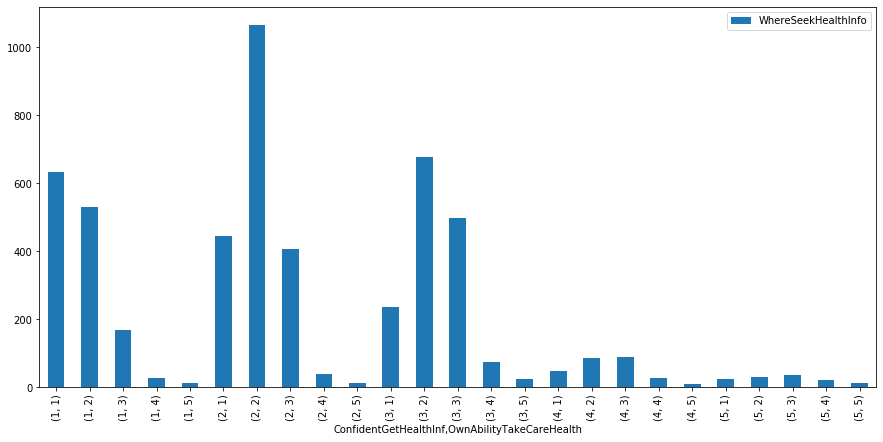

In [63]:
# ConfidentGetHealthInf vs OwnAbilityTakeCareHealth

analyse_data(new_df,'ConfidentGetHealthInf','OwnAbilityTakeCareHealth','WhereSeekHealthInfo')

(5119, 348)
                                             HHID  HIGHSPANLI  HISPSURNAME  \
ConfidentGetHealthInf EverythingCauseCancer                                  
1                     1                       333         333          333   
                      2                       546         546          546   
                      3                       244         244          244   
                      4                       210         210          210   
2                     1                       355         355          355   
                      2                       947         947          947   
                      3                       380         380          380   
                      4                       254         254          254   
3                     1                       311         311          311   
                      2                       738         738          738   
                      3                       297   

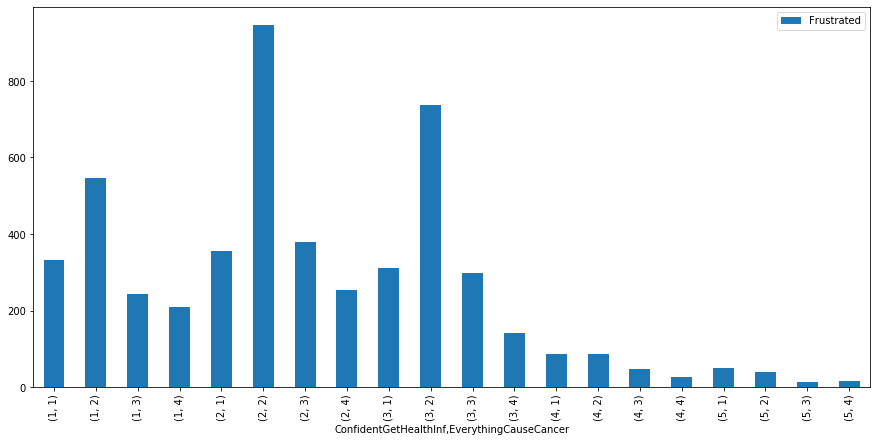

In [64]:
## ConfidentGetHealthInf vs EverythingCauseCancer

temp_df = new_df[(new_df['ConfidentGetHealthInf']>0) & (new_df['EverythingCauseCancer']>0)]
print(temp_df.shape)
print(temp_df.groupby(['ConfidentGetHealthInf','EverythingCauseCancer']).count())
temp = temp_df[['ConfidentGetHealthInf','EverythingCauseCancer','Frustrated']]
temp.groupby(['ConfidentGetHealthInf','EverythingCauseCancer']).count().plot(kind='bar', figsize = (15,7))

In [9]:
## ConfidentGetHealthInf vs OwnAbilityTakeCareHealth vs EverythingCauseCancer

temp_df = new_df[(new_df['ConfidentGetHealthInf']>0) & (new_df['OwnAbilityTakeCareHealth']>0) & (new_df['EverythingCauseCancer']>0)]
print(temp_df.shape)
pd.set_option('display.max_rows', 100)
temp_df.groupby(['ConfidentGetHealthInf','OwnAbilityTakeCareHealth', 'EverythingCauseCancer']).count().iloc[:,:2]

(5070, 348)


HHID  \
ConfidentGetHealthInf OwnAbilityTakeCareHealth EverythingCauseCancer         
1                     1                        1                       164   
                                               2                       217   
                                               3                       114   
                                               4                       110   
                      2                        1                       109   
                                               2                       240   
                                               3                        94   
                                               4                        73   
                      3                        1                        46   
                                               2                        74   
                                               3                        22   
                                               4                        21   
                      4                        1                         8   
                                               2                         7   
                                               3                        11   
                                               4                         1   
                      5                        1                         4   
                                               2                         2   
                                               3                         2   
                                               4                         3   
2                     1                        1                        72   
                                               2                       203   
                                               3                        91   
                                               4                        66   
                      2                        1                       193   
                                               2                       519   
                                               3                       202   
                                               4                       132   
                      3                        1                        79   
                                               2                       193   
                                               3                        79   
                                               4                        47   
                      4                        1                         6   
                                               2                        21   
                                               3                         6   
                                               4                         4   
                      5                        1                         4   
                                               2                         4   
                                               3                         1   
                                               4                         1   
3                     1                        1                        53   
                                               2                       100   
                                               3                        51   
                                               4                        25   
                      2                        1                       124   
                                               2                       333   
                                               3                       136   
                                               4                        67   
                      3                        1                       102   
                                               2                       254   
              

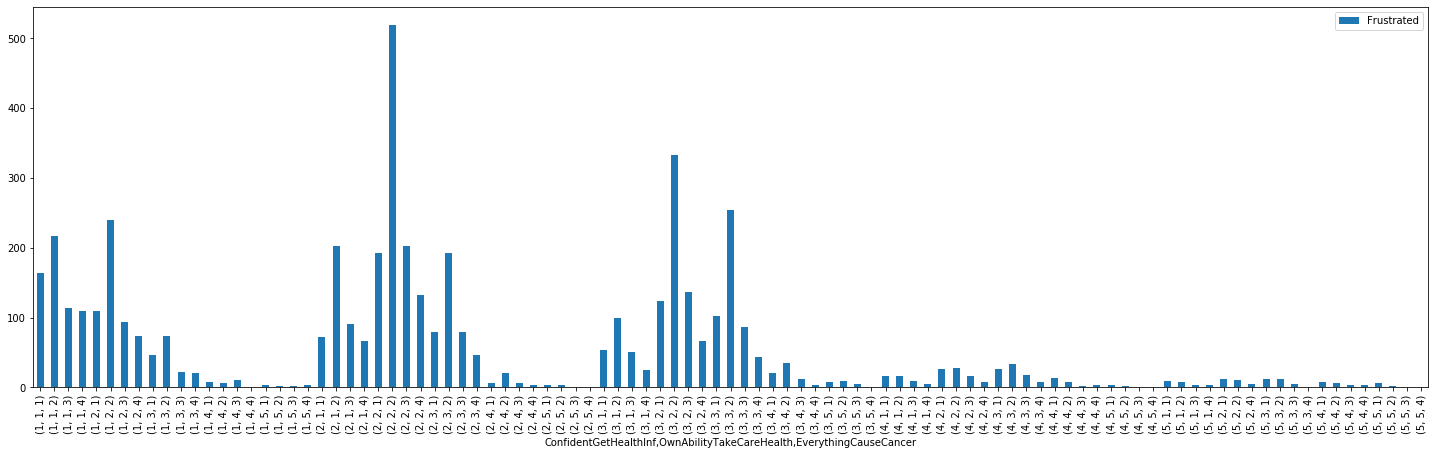

In [10]:
temp = temp_df[['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer','Frustrated']]
temp.groupby(['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer']).count().plot(kind='bar', figsize = (25,7))

### Q: How do people’s information-related self-efficacy (A5) and their health-related self-efficacy (F2 & N4) relate to their use of social media for health information seeking or sharing (B14)

In [66]:
#Trying a Regression here

#Target Column ConfidentGetHealthInf
y = new_df['OwnAbilityTakeCareHealth']
#feature Columns
x = new_df[['ConfidentGetHealthInf','EverythingCauseCancer',
            'Frustrated','GeneralHealth','AvoidDoc','TalkHealthFriends','IntRsn_VisitedSocNet','IntRsn_SharedSocNet',
           'IntRsn_WroteBlog','IntRsn_SupportGroup','IntRsn_YouTube',]]



#x = new_df[['ConfidentGetHealthInf','EverythingCauseCancer',
 #           'PreventNotPossible','TooManyRecommendations','Frustrated','GeneralHealth',
  #          'AvoidDoc','TalkHealthFriends','IntRsn_VisitedSocNet','IntRsn_SharedSocNet',
   #          'IntRsn_WroteBlog','IntRsn_SupportGroup','IntRsn_YouTube',]]
#define Multiple linear regression model
linear_regression = LinearRegression()
#fit the model
linear_regression.fit(x,y)

#getting results
r_sq = linear_regression.score(x,y)
print('coefficient of determination:', r_sq)

print('intercept:', linear_regression.intercept_)
print('slope:', linear_regression.coef_)


# predict with the data
y_pred = linear_regression.predict(x)
print('predicted response:', y_pred, sep='\n')

y_pred = linear_regression.intercept_ + np.sum(linear_regression.coef_ * x, axis=1)
print('predicted response:', y_pred, sep='\n')


coefficient of determination: 0.659971201927541
intercept: 0.028224335024482627
slope: [ 0.05713859  0.00680879 -0.00909621  0.46279876  0.20939186  0.26718978
 -0.0158949   0.01106157  0.00962245  0.02638334 -0.00796647]
predicted response:
[3.07312419 2.34864371 2.41902624 ... 2.54631446 2.10628298 1.36039954]
predicted response:
0       3.073124
1       2.348644
2       2.419026
3       1.853038
4       1.512344
          ...   
5433    2.610325
5434    2.363156
5435    2.546314
5436    2.106283
5437    1.360400
Length: 5438, dtype: float64


In [67]:
#another way googled this, but not sure
#Target Column ConfidentGetHealthInf
y = new_df['OwnAbilityTakeCareHealth']
#feature Columns
x = new_df[['ConfidentGetHealthInf','EverythingCauseCancer',
            'PreventNotPossible','TooManyRecommendations','Frustrated',
            'AvoidDoc','TalkHealthFriends','IntRsn_VisitedSocNet','IntRsn_SharedSocNet',
             'IntRsn_WroteBlog','IntRsn_SupportGroup','IntRsn_YouTube',]]

x = sm.add_constant(x)
linear_regression = sm.OLS(y, x)
results = linear_regression.fit()

print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params)
print('T Test :', results.tvalues)

results.summary()

coefficient of determination: 0.5321657029115209
adjusted coefficient of determination: 0.5311308620700348
regression coefficients: const                     0.566647
ConfidentGetHealthInf     0.078026
EverythingCauseCancer    -0.000545
PreventNotPossible        0.007332
TooManyRecommendations   -0.000098
Frustrated               -0.021038
AvoidDoc                  0.405103
TalkHealthFriends         0.497423
IntRsn_VisitedSocNet      0.030862
IntRsn_SharedSocNet       0.004907
IntRsn_WroteBlog         -0.011031
IntRsn_SupportGroup       0.032680
IntRsn_YouTube           -0.023930
dtype: float64
T Test : const                     16.864687
ConfidentGetHealthInf      9.802236
EverythingCauseCancer     -0.051094
PreventNotPossible         0.774808
TooManyRecommendations    -0.009419
Frustrated                -3.857159
AvoidDoc                  23.035731
TalkHealthFriends         27.070563
IntRsn_VisitedSocNet       1.552818
IntRsn_SharedSocNet        0.219524
IntRsn_WroteBlog          -0.

/Users/sanaamironov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     OwnAbilityTakeCareHealth   R-squared:                       0.532
Model:                                  OLS   Adj. R-squared:                  0.531
Method:                       Least Squares   F-statistic:                     514.2
Date:                      Thu, 27 Feb 2020   Prob (F-statistic):               0.00
Time:                              17:40:59   Log-Likelihood:                -8299.6
No. Observations:                      5438   AIC:                         1.663e+04
Df Residuals:                          5425   BIC:                         1.671e+04
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.5666      0.034     16.865      0.000       0.501       0.633
ConfidentGetHealthInf      0.0780      0.008      9.802      0.000       0.062       0.094
EverythingCauseCancer     -0.0005      0.011     -0.051      0.959      -0.021       0.020
PreventNotPossible         0.0073      0.009      0.775      0.438      -0.011       0.026
TooManyRecommendations -9.835e-05      0.010     -0.009      0.992      -0.021       0.020
Frustrated                -0.0210      0.005     -3.857      0.000      -0.032      -0.010
AvoidDoc                   0.4051      0.018     23.036      0.000       0.371       0.440
TalkHealthFriends          0.4974      0.018     27.071      0.000       0.461       0.533
IntRsn_VisitedSocNet       0.0309      0.020      1.553      0.121      -0.008       0.070
IntRsn_SharedSocNet        0.0049      0.022      0.220      0.826      -0.039       0.049
IntRsn_WroteBlog          -0.0110      0.023     -0.473      0.636      -0.057       0.035
IntRsn_SupportGroup        0.0327      0.030      1.097      0.273      -0.026       0.091
IntRsn_YouTube            -0.0239      0.018     -1.311      0.190      -0.060       0.012
==============================================================================
Omnibus:                     1853.883   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91487.689
Skew:                          -0.865   Prob(JB):                         0.00
Kurtosis:                      23.019   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
#another way
y = new_df['IntRsn_VisitedSocNet']
#feature Columns
x = new_df[['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer','PreventNotPossible','TooManyRecommendations']]

x = sm.add_constant(x)
linear_regression = sm.OLS(y, x)
results = linear_regression.fit()

print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params)
print('T Test :', results.tvalues)

results.summary()



coefficient of determination: 0.015340108489671378
adjusted coefficient of determination: 0.014433757337692033
regression coefficients: const                       1.001271
ConfidentGetHealthInf      -0.005650
OwnAbilityTakeCareHealth    0.067895
EverythingCauseCancer       0.016489
PreventNotPossible          0.015217
TooManyRecommendations      0.013782
dtype: float64
T Test : const                       29.954413
ConfidentGetHealthInf       -0.630743
OwnAbilityTakeCareHealth     6.220586
EverythingCauseCancer        1.346310
PreventNotPossible           1.416522
TooManyRecommendations       1.150625
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     IntRsn_VisitedSocNet   R-squared:                       0.015
Model:                              OLS   Adj. R-squared:                  0.014
Method:                   Least Squares   F-statistic:                     16.93
Date:                  Wed, 26 Feb 2020   Prob (F-statistic):           1.22e-16
Time:                          22:21:15   Log-Likelihood:                -9065.4
No. Observations:                  5438   AIC:                         1.814e+04
Df Residuals:                      5432   BIC:                         1.818e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.0013      0.033     29.954      0.000       0.936       1.067
ConfidentGetHealthInf       -0.0056      0.009     -0.631      0.528      -0.023       0.012
OwnAbilityTakeCareHealth     0.0679      0.011      6.221      0.000       0.046       0.089
EverythingCauseCancer        0.0165      0.012      1.346      0.178      -0.008       0.040
PreventNotPossible           0.0152      0.011      1.417      0.157      -0.006       0.036
TooManyRecommendations       0.0138      0.012      1.151      0.250      -0.010       0.037
==============================================================================
Omnibus:                     6406.814   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           554958.839
Skew:                          -6.386   Prob(JB):                         0.00
Kurtosis:                      50.813   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#Trying a Linear Regression here

#Target Column ConfidentGetHealthInf
y = new_df['IntRsn_SharedSocNet']
#feature Columns
x = new_df[['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer','PreventNotPossible','TooManyRecommendations']]

#define Multiple linear regression model
linear_regression = LinearRegression()
#fit the model
linear_regression.fit(x,y)
# predict with the data
y_pred = linear_regression.predict(x)

y_pred


array([1.82504371, 1.80941261, 0.85689816, ..., 1.83897612, 1.67289749,
       1.67289749])

In [35]:
linear_regression = sm.OLS(y, x)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     IntRsn_VisitedSocNet   R-squared (uncentered):                   0.388
Model:                              OLS   Adj. R-squared (uncentered):              0.388
Method:                   Least Squares   F-statistic:                              689.5
Date:                  Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                          21:53:00   Log-Likelihood:                         -9481.0
No. Observations:                  5438   AIC:                                  1.897e+04
Df Residuals:                      5433   BIC:                                  1.901e+04
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ConfidentGetHealthInf        0.1164      0.009     13.517      0.000       0.100       0.133
OwnAbilityTakeCareHealth     0.2285      0.010     22.269      0.000       0.208       0.249
EverythingCauseCancer        0.0430      0.013      3.259      0.001       0.017       0.069
PreventNotPossible           0.0850      0.011      7.513      0.000       0.063       0.107
TooManyRecommendations      -0.0015      0.013     -0.114      0.909      -0.027       0.024
==============================================================================
Omnibus:                     5179.579   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           289566.178
Skew:                          -4.539   Prob(JB):                         0.00
Kurtosis:                      37.577   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
#Trying a Linear Regression here

#Target Column ConfidentGetHealthInf
y = new_df['IntRsn_WroteBlog']
#feature Columns
x = new_df[['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer','PreventNotPossible','TooManyRecommendations']]

#define Multiple linear regression model
linear_regression = LinearRegression()
#fit the model
linear_regression.fit(x,y)
# predict with the data
y_pred = linear_regression.predict(x)

y_pred


array([1.88903449, 1.90621683, 0.77957242, ..., 1.90407833, 1.77185416,
       1.77185416])

In [37]:
linear_regression = sm.OLS(y, x)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       IntRsn_WroteBlog   R-squared (uncentered):                   0.507
Model:                            OLS   Adj. R-squared (uncentered):              0.507
Method:                 Least Squares   F-statistic:                              1119.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:54:27   Log-Likelihood:                         -10310.
No. Observations:                5438   AIC:                                  2.063e+04
Df Residuals:                    5433   BIC:                                  2.066e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ConfidentGetHealthInf        0.1905      0.010     18.999      0.000       0.171       0.210
OwnAbilityTakeCareHealth     0.2852      0.012     23.865      0.000       0.262       0.309
EverythingCauseCancer        0.0411      0.015      2.678      0.007       0.011       0.071
PreventNotPossible           0.1804      0.013     13.686      0.000       0.155       0.206
TooManyRecommendations      -0.0155      0.015     -1.027      0.304      -0.045       0.014
==============================================================================
Omnibus:                     4830.479   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           215614.476
Skew:                          -4.128   Prob(JB):                         0.00
Kurtosis:                      32.723   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
#Trying a Linear Regression here

#Target Column ConfidentGetHealthInf
y = new_df['IntRsn_SupportGroup']
#feature Columns
x = new_df[['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer','PreventNotPossible','TooManyRecommendations']]

#define Multiple linear regression model
linear_regression = LinearRegression()
#fit the model
linear_regression.fit(x,y)
# predict with the data
y_pred = linear_regression.predict(x)

y_pred


array([1.90694434, 1.89997983, 0.90787884, ..., 1.89764527, 1.74386804,
       1.74386804])

In [39]:
linear_regression = sm.OLS(y, x)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     IntRsn_SupportGroup   R-squared (uncentered):                   0.522
Model:                             OLS   Adj. R-squared (uncentered):              0.521
Method:                  Least Squares   F-statistic:                              1185.
Date:                 Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                         21:55:49   Log-Likelihood:                         -10101.
No. Observations:                 5438   AIC:                                  2.021e+04
Df Residuals:                     5433   BIC:                                  2.025e+04
Df Model:                            5                                                  
Covariance Type:             nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ConfidentGetHealthInf        0.1893      0.010     19.617      0.000       0.170       0.208
OwnAbilityTakeCareHealth     0.2962      0.012     25.752      0.000       0.274       0.319
EverythingCauseCancer        0.0395      0.015      2.676      0.007       0.011       0.069
PreventNotPossible           0.1665      0.013     13.127      0.000       0.142       0.191
TooManyRecommendations      -0.0117      0.014     -0.808      0.419      -0.040       0.017
==============================================================================
Omnibus:                     4828.679   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235407.263
Skew:                          -4.087   Prob(JB):                         0.00
Kurtosis:                      34.179   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
#Trying a Linear Regression here

#Target Column ConfidentGetHealthInf
y = new_df['IntRsn_YouTube']
#feature Columns
x = new_df[['ConfidentGetHealthInf','OwnAbilityTakeCareHealth','EverythingCauseCancer','PreventNotPossible','TooManyRecommendations']]

#define Multiple linear regression model
linear_regression = LinearRegression()
#fit the model
linear_regression.fit(x,y)
# predict with the data
y_pred = linear_regression.predict(x)

y_pred


array([1.58227874, 1.57179001, 0.59609594, ..., 1.61610925, 1.47102771,
       1.47102771])

In [41]:
linear_regression = sm.OLS(y, x)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         IntRsn_YouTube   R-squared (uncentered):                   0.416
Model:                            OLS   Adj. R-squared (uncentered):              0.416
Method:                 Least Squares   F-statistic:                              774.3
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        21:55:56   Log-Likelihood:                         -10323.
No. Observations:                5438   AIC:                                  2.066e+04
Df Residuals:                    5433   BIC:                                  2.069e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ConfidentGetHealthInf        0.1486      0.010     14.784      0.000       0.129       0.168
OwnAbilityTakeCareHealth     0.2443      0.012     20.394      0.000       0.221       0.268
EverythingCauseCancer        0.0455      0.015      2.955      0.003       0.015       0.076
PreventNotPossible           0.1431      0.013     10.832      0.000       0.117       0.169
TooManyRecommendations      -0.0107      0.015     -0.712      0.476      -0.040       0.019
==============================================================================
Omnibus:                     4800.536   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           181850.611
Skew:                          -4.158   Prob(JB):                         0.00
Kurtosis:                      30.082   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
y1 = new_df['ConfidentGetHealthInf']
X1 = new_df[['OwnAbilityTakeCareHealth','EverythingCauseCancer','Frustrated','GeneralHealth','AvoidDoc','TalkHealthFriends']]
print(X1.shape, y1.shape)
reg = linear_model.LinearRegression()
reg_output1 = reg.fit(X1,y1)
print(reg_output1.coef_)

(5438, 6) (5438,)
[ 0.22690663  0.01168242  0.14689914 -0.00600704 -0.2095721   0.000774  ]


In [14]:
linear_regression = sm.OLS(y1, X1)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     ConfidentGetHealthInf   R-squared (uncentered):                   0.441
Model:                               OLS   Adj. R-squared (uncentered):              0.441
Method:                    Least Squares   F-statistic:                              715.3
Date:                   Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                           21:15:26   Log-Likelihood:                         -11626.
No. Observations:                   5438   AIC:                                  2.326e+04
Df Residuals:                       5432   BIC:                                  2.330e+04
Df Model:                              6                                                  
Covariance Type:               nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
OwnAbilityTakeCareHealth     0.3016      0.029     10.395      0.000       0.245       0.358
EverythingCauseCancer        0.1155      0.012      9.405      0.000       0.091       0.140
Frustrated                   0.2116      0.009     22.519      0.000       0.193       0.230
GeneralHealth                0.2850      0.024     11.911      0.000       0.238       0.332
AvoidDoc                     0.0035      0.033      0.105      0.916      -0.062       0.069
TalkHealthFriends           -0.2870      0.035     -8.206      0.000      -0.356      -0.218
==============================================================================
Omnibus:                     2599.028   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29968.529
Skew:                          -1.992   Prob(JB):                         0.00
Kurtosis:                      13.788   Cond. No.                         7.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Model with Every feature in it
y2 = new_df['ConfidentGetHealthInf']
X2 = new_df[['OwnAbilityTakeCareHealth','EverythingCauseCancer','Frustrated','IntRsn_VisitedSocNet','IntRsn_SharedSocNet',
             'IntRsn_WroteBlog','IntRsn_SupportGroup','IntRsn_YouTube','GeneralHealth','AvoidDoc','TalkHealthFriends']]
print(X2.shape, y2.shape)
reg = linear_model.LinearRegression()
reg_output2 = reg.fit(X2,y2)
print(reg_output2.coef_)

(5438, 11) (5438,)
[ 0.2250038   0.01073978  0.14422649 -0.05283662 -0.04197749  0.02074025
  0.10340946 -0.0314157  -0.00392598 -0.21071203  0.00041217]


In [22]:
linear_regression = sm.OLS(y2, X2)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     ConfidentGetHealthInf   R-squared (uncentered):                   0.466
Model:                               OLS   Adj. R-squared (uncentered):              0.465
Method:                    Least Squares   F-statistic:                              429.9
Date:                   Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                           21:42:43   Log-Likelihood:                         -11505.
No. Observations:                   5438   AIC:                                  2.303e+04
Df Residuals:                       5427   BIC:                                  2.310e+04
Df Model:                             11                                                  
Covariance Type:               nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
OwnAbilityTakeCareHealth     0.2653      0.028      9.314      0.000       0.209       0.321
EverythingCauseCancer        0.0722      0.012      5.843      0.000       0.048       0.096
Frustrated                   0.1800      0.009     19.061      0.000       0.162       0.199
IntRsn_VisitedSocNet        -0.1047      0.036     -2.930      0.003      -0.175      -0.035
IntRsn_SharedSocNet          0.0238      0.040      0.591      0.554      -0.055       0.103
IntRsn_WroteBlog             0.1237      0.042      2.960      0.003       0.042       0.206
IntRsn_SupportGroup          0.2662      0.053      4.995      0.000       0.162       0.371
IntRsn_YouTube              -0.0769      0.033     -2.340      0.019      -0.141      -0.012
GeneralHealth                0.2203      0.024      9.238      0.000       0.174       0.267
AvoidDoc                    -0.0441      0.033     -1.347      0.178      -0.108       0.020
TalkHealthFriends           -0.2394      0.034     -6.960      0.000      -0.307      -0.172
==============================================================================
Omnibus:                     2831.753   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35550.871
Skew:                          -2.199   Prob(JB):                         0.00
Kurtosis:                      14.728   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""